# Use-Case: Using CausalPlayground to Compare Causal Discovery Algorithms

In this use-case, we will explore how to use the CausalPlayground library to compare different causal discovery algorithms. We will generate synthetic data using the library's built-in functions and evaluate the performance of the algorithms on both confounded and unconfounded, automatically generated SCMs.

## Installing Required Packages

Before running this notebook, make sure you have the necessary packages installed. You can install them using the following commands:


In [ ]:
!pip install castle
!pip install causal-playground
!pip install networkx
!pip install pandas
!pip install matplotlib

Now, let's import the necessary libraries and modules. We will use CaisalPlayground to generate many SCM instances and the gCastle [1] package for implementations of the causal discovery algorithms.

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from numpy.linalg import LinAlgError
import random
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

from castle.metrics import MetricsDAG
from castle.algorithms import PC, GES, Notears

from CausalPlayground import *

## Setting Hyperparameters

We define the hyperparameters for our analysis, including the number of SCMs to evaluate and the algorithms to compare. Note that the number of SCMs that will be evaluated influences the runtime later in this notebook.

In [ ]:
n_scms = 30  # how many SCMs should be generated
n_samples = 100 # how many data points to sample from each SCM
algos = {'PC': PC, 'GES': GES, 'NOTEARS': Notears}  # which algorithms should be compared

## Generating Causal Graphs

We generate distinct confounded and unconfounded causal graphs using the `CausalGraphSetGenerator` class from CausalPlayground. Each of the sets has 4 endogenous variables and 4 exogenous variables. 

In [ ]:
generator = CausalGraphSetGenerator(n_endo=4, n_exo=4, allow_exo_confounders=False)
generator.generate(n_scms)
graphs_unconfounded = generator.graphs

generator = CausalGraphSetGenerator(n_endo=4, n_exo=4, allow_exo_confounders=True)
generator.generate(n_scms)
graphs_confounded = generator.graphs


The outputs show the progress on how many graphs have already been added to the set, and how many graphs had to be resampled because they were already in the set.
## Generating SCMs

First, we have to define a function class from which to draw the causal relations of our SCM. For the sake of this experiment, we choose linear functions and an interaction function as defined below. The linear function adds all causal parents, the interaction function multiplies all causal parents. Both functions add gaussian noise.

In [ ]:
def f_linear(parents):
    weights = {p: random.uniform(0.5, 2.0) for p in parents}
    default_value = 0.0

    def f(**kwargs):
        if len(kwargs) == 0:
            mu = default_value
        else:
            mu = 0.0

        for p in parents:
            mu += weights[p] * kwargs[p]
        return mu + random.gauss(0, 0.5)

    return f

def f_interaction(parents):
    weights = {p: random.uniform(0.5, 2.0) for p in parents}
    default_value = 1.0

    def f(**kwargs):
        if len(kwargs) == 0:
            mu = default_value
        else:
            mu = 1.0

        for p in parents:
            mu *= weights[p] * kwargs[p]
        return mu + random.gauss(0, 0.5)

    return f


We generate the SCMs for evaluation using the `SCMGenerator` class from CausalPlayground. We create SCMs for both confounded and unconfounded graphs by generating SCMs based on the graph structures generated before. The causal relations are determined by the `f_linear` and `f_interaction` function defined above. More specifically, for every endogenous variable, the function is drawn from either of the two classes.

In [ ]:
generator = SCMGenerator(all_functions={"linear": f_linear, "interaction": f_interaction}, seed=42)

scms_unconfounded = [generator.create_scm_from_graph(graph,
                                                     possible_functions=['linear', 'interaction'],
                                                     exo_distribution=random.gauss,
                                                     exo_distribution_kwargs={'mu': 0, 'sigma': 1})
                     for graph in graphs_unconfounded]

scms_confounded = [generator.create_scm_from_graph(graph,
                                                   possible_functions=['linear', 'interaction'],
                                                   exo_distribution=random.gauss,
                                                   exo_distribution_kwargs={'mu': 0, 'sigma': 1})
                   for graph in graphs_confounded]

## Initializing Results

We initialize a dictionary to store the evaluation results for each algorithm and dataset configuration. By creating a `pandas.DataFrame` for each algorithm for the confounded and the unconfounded case. 

In [ ]:
metrics = ['fdr', 'tpr', 'fpr', 'shd', 'nnz', 'precision', 'recall', 'F1', 'gscore']
results = {algo: {'uconf': pd.DataFrame(columns=metrics), 'conf': pd.DataFrame(columns=metrics)} for algo in algos.keys()}

## Evaluating Algorithms

We iterate over the generated SCMs and evaluate the performance of each algorithm on both confounded and unconfounded datasets. This will take a few minutes.

In [ ]:
for scm_uconf, scm_conf in zip(scms_unconfounded, scms_confounded):
    # Create the SCMEnvironments to interact with the SCMs
    env_uconf = SCMEnvironment(scm_uconf, possible_interventions=[])
    env_conf = SCMEnvironment(scm_conf, possible_interventions=[])
    
    # Step through the environment to collect [n_samples] samples.
    [env_uconf.step([0]) for _ in range(n_samples)]
    [env_conf.step([0]) for _ in range(n_samples)]
    
    # retrieve the samples
    samples_uconf = env_uconf.samples_so_far.to_numpy()
    samples_conf = env_conf.samples_so_far.to_numpy()
    
    for a in algos.keys():
        algo = algos[a]()
        
        # Unconfounded case
        try:
            algo.learn(samples_uconf)
        except LinAlgError or ValueError:  # Discard SCMs that lead to degenerate data matricies
            continue
        
        # calculate the metrics and add them to the right dataframe
        mt = MetricsDAG(algo.causal_matrix, nx.to_numpy_array(scm_uconf.create_graph()))
        results[a]['uconf'].loc[len(results[a]['uconf'])] = mt.metrics
        
        # Unconfounded case
        try:
            algo.learn(samples_conf)
        except LinAlgError or ValueError:  # Discard SCMs that lead to degenerate data matricies
            continue
        
        # calculate the metrics and add them to the right dataframe
        mt = MetricsDAG(algo.causal_matrix, nx.to_numpy_array(scm_conf.create_graph()))
        results[a]['conf'].loc[len(results[a]['conf'])] = mt.metrics
        
print('Finished evaluation')

## Plotting Results

Finally, we visualize the evaluation results by plotting the average values of selected metrics for each algorithm and dataset configuration. We decide to plot the F1 score and tpr.

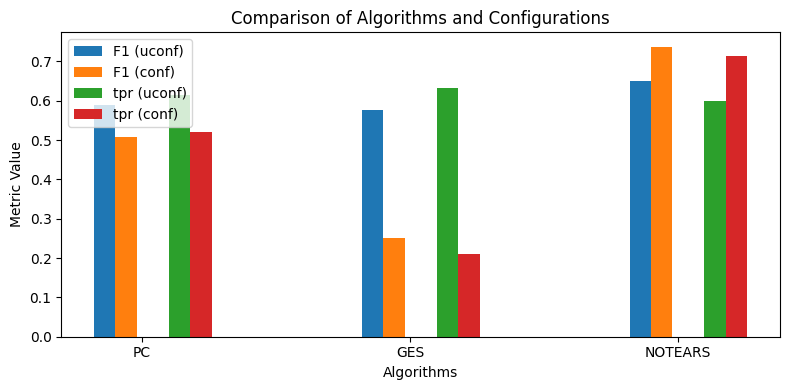

In [53]:
metrics_to_plot = ['F1',  'tpr']
def plot_results():
    algos_list = list(algos.keys())
    
    plot_data = {metric: {'uconf': [], 'conf': []} for metric in metrics_to_plot}
    for algo in algos_list:
        for metric in metrics_to_plot:
            plot_data[metric]['uconf'].append(results[algo]['uconf'][metric].mean())
            plot_data[metric]['conf'].append(results[algo]['conf'][metric].mean())
    
    fig, ax = plt.subplots(figsize=(8, 4))
    bar_width = 0.08
    group_spacing = 0.2
    x = np.arange(len(algos_list))
    
    for i, metric in enumerate(metrics_to_plot):
        ax.bar(x + i * (bar_width + group_spacing), plot_data[metric]['uconf'], width=bar_width, label=f'{metric} (uconf)')
        ax.bar(x + i * (bar_width + group_spacing) + bar_width, plot_data[metric]['conf'], width=bar_width, label=f'{metric} (conf)')
    
    ax.set_xticks(x + (len(metrics_to_plot) - 1) * (bar_width + group_spacing) / 2)
    ax.set_xticklabels(algos_list)
    
    ax.set_ylabel('Metric Value')
    ax.set_xlabel('Algorithms')
    ax.set_title('Comparison of Algorithms and Configurations')
    
    ax.legend()
    plt.tight_layout()
    plt.show()
    
plot_results()

One take-away from this analisys could be that, on average, the presented CD algorithms perform worse on confounded graphs, except for NOTEARS. With adaptations to the causal relations, the metrics that are displayed and the CD algorithms, more intricate conclusions could be drawn.
## Conclusion

In this notebook, we demonstrated how to use the CausalPlayground library to compare different causal discovery algorithms. We generated synthetic data using the library's built-in functions and evaluated the performance of the algorithms on both confounded and unconfounded datasets. We show the usefulness of our library for generating causal data.


## References
[1] Keli Zhang, Shengyu Zhu, Marcus Kalander, Ignavier Ng, Junjian Ye, Zhitang Chen, and Lujia Pan. gCastle: A Python Toolbox for Causal Discovery. 11 2021
